## DC House Price

#### Project goal: 

- Predict the median house price in DC
- use the right housing statistics and macro variables: (1) time series, (2) acf/pacf plots, (3) stationary test and (4) autocorrelation test
- Modeling: time series linear regression: feature selection in R-squared, AIC, etc.
- Cross validation: Out-of-time performance
- Residual analysis: (1) normality test, (2) Q-Q plot, (3) MAE, (4) MAPE, (5) Homoscedastic test, (6) stationary test and (7) autocorrelation test 

In [89]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.compat import lzip

%matplotlib inline

In [93]:
# feature selection: KBest using f_regression, chi2, mutual_info_regression
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, chi2, mutual_info_regression

# tests for stationary 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

import statsmodels.api as sm

#tests for autocorrelation
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox

#test of Heteroscedasticity
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_goldfeldquandt

#test for cointegration
from statsmodels.tsa.vector_ar.vecm import coint_johansen 

In [3]:
df = pd.read_csv("../data/full_data.csv")

In [4]:
df_test = df.drop(columns=['Time', 'DATE', 'Median Sale Price MoM', 'New Listings MoM', 'Homes Sold MoM', 'Inventory MoM', 'Days on Market MoM', 'Average Sale To List MoM', 'DC_PER'])
col_name = df_test.columns

In [5]:
# create a log transformed variable
for i in range(len(col_name)):
    df[col_name[i] + '_log'] =  np.log(df[col_name[i]])

In [6]:
df_test = df.drop(columns=['Time', 'DATE'])
col_name = df_test.columns
col_name

Index(['Median Sale Price', 'Median Sale Price MoM', 'Homes Sold',
       'Homes Sold MoM', 'New Listings', 'New Listings MoM', 'Inventory',
       'Inventory MoM', 'Days on Market', 'Days on Market MoM',
       'Average Sale To List%', 'Average Sale To List MoM', 'WDXRSA', 'US_UR',
       'DMV_UR', 'DC_UR', 'FED_EM', 'FIN_EM', 'HOS_EM', 'DC_PER', 'DMV_PER',
       'DMV_PER_1', 'Median Sale Price_log', 'Homes Sold_log',
       'New Listings_log', 'Inventory_log', 'Days on Market_log',
       'Average Sale To List%_log', 'WDXRSA_log', 'US_UR_log', 'DMV_UR_log',
       'DC_UR_log', 'FED_EM_log', 'FIN_EM_log', 'HOS_EM_log', 'DMV_PER_log',
       'DMV_PER_1_log'],
      dtype='object')

In [7]:
df.isnull().sum()

Time                         0
Median Sale Price            0
Median Sale Price MoM        0
Homes Sold                   0
Homes Sold MoM               0
New Listings                 0
New Listings MoM             0
Inventory                    0
Inventory MoM                0
Days on Market               0
Days on Market MoM           0
Average Sale To List%        0
Average Sale To List MoM     0
DATE                         0
WDXRSA                       0
US_UR                        0
DMV_UR                       0
DC_UR                        0
FED_EM                       0
FIN_EM                       0
HOS_EM                       0
DC_PER                       0
DMV_PER                      0
DMV_PER_1                    0
Median Sale Price_log        0
Homes Sold_log               0
New Listings_log             0
Inventory_log                0
Days on Market_log           0
Average Sale To List%_log    0
WDXRSA_log                   0
US_UR_log                    0
DMV_UR_l

In [8]:
df.isna().sum()

Time                         0
Median Sale Price            0
Median Sale Price MoM        0
Homes Sold                   0
Homes Sold MoM               0
New Listings                 0
New Listings MoM             0
Inventory                    0
Inventory MoM                0
Days on Market               0
Days on Market MoM           0
Average Sale To List%        0
Average Sale To List MoM     0
DATE                         0
WDXRSA                       0
US_UR                        0
DMV_UR                       0
DC_UR                        0
FED_EM                       0
FIN_EM                       0
HOS_EM                       0
DC_PER                       0
DMV_PER                      0
DMV_PER_1                    0
Median Sale Price_log        0
Homes Sold_log               0
New Listings_log             0
Inventory_log                0
Days on Market_log           0
Average Sale To List%_log    0
WDXRSA_log                   0
US_UR_log                    0
DMV_UR_l

In [9]:
adfuller(df[col_name[36]], regression = 'ct')

(-3.2930742362239633,
 0.06739888528454135,
 2,
 114,
 {'1%': -4.0404611509884285,
  '5%': -3.449728197718056,
  '10%': -3.1500478236218434},
 -142.95436871641422)

#### Only focus on KPSS and DW test

In [10]:
# %load ../python_folder/python_files/test_matrix_kpss_dw

In [11]:
# p-value for adfuller
p_val_adf = []

# p-value for kpss
p_val_kpss = []

# p-value for acorr_breusch_godfrey 
p_val_bg = []

# p-value for Ljung–Box Q test
p_val_lj = []

# statistic for durbin_watson
stat_dw = []

for i in range(len(col_name)):
    temp = adfuller(df[col_name[i]], regression = 'ct')
    p_val_adf.append(temp[1])
    
    temp = kpss(df[col_name[i]], regression = 'ct')
    p_val_kpss.append(temp[1])
    
    temp = acorr_ljungbox(df[col_name[i]], lags = 10)
    p_val_lj.append(temp[1][0])
    
    temp = durbin_watson(df[col_name[i]])
    stat_dw.append(temp)

test_matrix = pd.DataFrame(list(zip(col_name, p_val_adf, p_val_kpss, p_val_lj, stat_dw)), 
               columns =['Features','p_adftest', 'p_kpsstest','p_ljtest', 'stat_dw'])
    

/Users/cslsh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/Users/cslsh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/Users/cslsh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/Users/cs

In [12]:
test_matrix

,Features,p_adftest,p_kpsstest,p_ljtest,stat_dw
0,Median Sale Price,1.852913e-03,0.048158,5.860334e-23,1.460217e-03
1,Median Sale Price MoM,4.774490e-07,0.100000,1.510148e-02,2.351027e+00
2,Homes Sold,9.371101e-01,0.100000,5.742783e-16,2.136036e-02
3,Homes Sold MoM,7.690392e-02,0.100000,7.062849e-01,2.040086e+00
4,New Listings,9.164763e-01,0.100000,3.455617e-13,4.232778e-02
5,New Listings MoM,4.836519e-01,0.100000,9.330193e-01,1.955755e+00
6,Inventory,1.227744e-02,0.085247,3.028106e-25,5.105290e-03
7,Inventory MoM,9.186213e-01,0.100000,3.047694e-07,1.057099e+00
8,Days on Market,4.751578e-02,0.100000,1.495454e-19,4.371311e-02
9,Days on Market MoM,2.668512e-01,0.100000,4.162127e-03,1.471667e+00


In [13]:
# %load ../python_folder/python_files/Test_p_value

In [14]:
# Create a function to detect the hypothesis testing results. 1: reject null, 0: fail to reject null
def test_p_value(p = .05, name = 'ttest'):
    name_list = []
    for i in range(len(test_matrix)):
        if test_matrix["p_" + name][i] < p:
            name_list.append(1) 
        else:
            name_list.append(0)   
    test_matrix['index_' + name] = name_list

In [15]:
test_p_value(p = .05, name = 'adftest')
test_p_value(p = .05, name = 'kpsstest')
test_p_value(p = .05, name = 'ljtest')
test_matrix

,Features,p_adftest,p_kpsstest,p_ljtest,stat_dw,index_adftest,index_kpsstest,index_ljtest
0,Median Sale Price,1.852913e-03,0.048158,5.860334e-23,1.460217e-03,1,1,1
1,Median Sale Price MoM,4.774490e-07,0.100000,1.510148e-02,2.351027e+00,1,0,1
2,Homes Sold,9.371101e-01,0.100000,5.742783e-16,2.136036e-02,0,0,1
3,Homes Sold MoM,7.690392e-02,0.100000,7.062849e-01,2.040086e+00,0,0,0
4,New Listings,9.164763e-01,0.100000,3.455617e-13,4.232778e-02,0,0,1
5,New Listings MoM,4.836519e-01,0.100000,9.330193e-01,1.955755e+00,0,0,0
6,Inventory,1.227744e-02,0.085247,3.028106e-25,5.105290e-03,1,0,1
7,Inventory MoM,9.186213e-01,0.100000,3.047694e-07,1.057099e+00,0,0,1
8,Days on Market,4.751578e-02,0.100000,1.495454e-19,4.371311e-02,1,0,1
9,Days on Market MoM,2.668512e-01,0.100000,4.162127e-03,1.471667e+00,0,0,1


In [16]:
# Save the final testing results in data folder
test_matrix.to_csv('../data/TM_test.csv')

In [17]:
# Find all features are stationary and autocorrelation 0 based on both KPSS and DW tests
index_kpss = test_matrix['index_kpsstest'] == 0
index_lj = test_matrix['index_ljtest'] == 0
test_col = list(test_matrix[index_kpss & index_lj]["Features"])
test_col

['Homes Sold MoM', 'New Listings MoM', 'Average Sale To List MoM']

In [18]:
index_dw1 = test_matrix['index_ljtest'] >= 1 
index_dw2 = test_matrix['index_ljtest'] <= 3 
test_col = list(test_matrix[index_kpss & index_dw1 & index_dw2]["Features"])
test_col

['Median Sale Price MoM',
 'Homes Sold',
 'New Listings',
 'Inventory',
 'Inventory MoM',
 'Days on Market',
 'Days on Market MoM',
 'Average Sale To List%',
 'WDXRSA',
 'DMV_UR',
 'DC_UR',
 'FIN_EM',
 'HOS_EM',
 'DC_PER',
 'DMV_PER',
 'DMV_PER_1',
 'Homes Sold_log',
 'New Listings_log',
 'Inventory_log',
 'Days on Market_log',
 'Average Sale To List%_log',
 'WDXRSA_log',
 'US_UR_log',
 'DC_UR_log',
 'FED_EM_log',
 'FIN_EM_log',
 'DMV_PER_log',
 'DMV_PER_1_log']

In [19]:
test_col.remove('Median Sale Price MoM')
test_col

['Homes Sold',
 'New Listings',
 'Inventory',
 'Inventory MoM',
 'Days on Market',
 'Days on Market MoM',
 'Average Sale To List%',
 'WDXRSA',
 'DMV_UR',
 'DC_UR',
 'FIN_EM',
 'HOS_EM',
 'DC_PER',
 'DMV_PER',
 'DMV_PER_1',
 'Homes Sold_log',
 'New Listings_log',
 'Inventory_log',
 'Days on Market_log',
 'Average Sale To List%_log',
 'WDXRSA_log',
 'US_UR_log',
 'DC_UR_log',
 'FED_EM_log',
 'FIN_EM_log',
 'DMV_PER_log',
 'DMV_PER_1_log']

In [20]:
# split In-Time and Out-of-Time samples 

In [199]:
train_x = df[test_col][0:100]
test_x = df[test_col][101:117]

In [21]:
train_x = df[test_col][0:100]
test_x = df[test_col][101:117]
train_y = df["Median Sale Price"][0:100]
test_y = df["Median Sale Price"][101:117]

In [22]:
# feature selection: forward/backward stepwise regression and KBest

In [25]:
result = stepwise_selection(train_x, train_y, threshold_in = 0.1, threshold_out = 0.15)

/Users/cslsh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  WDXRSA_log                     with p-value 2.50628e-33
Add  Days on Market                 with p-value 1.82053e-17
Add  FIN_EM                         with p-value 2.43286e-05
Add  DC_UR_log                      with p-value 0.0682813


In [26]:
print('resulting features:')
print(result)

resulting features:
['WDXRSA_log', 'Days on Market', 'FIN_EM', 'DC_UR_log']


In [187]:
# %load ../python_folder/python_files/ForwardBackwardStepwiseRegression

In [24]:
#from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import statsmodels.api as sm

#data = load_boston()
#X = pd.DataFrame(data.data, columns=data.feature_names)
#y = data.target


def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin() # change argmin to idxmin
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

#result = stepwise_selection(X, y)

#print('resulting features:')
#print(result)

In [205]:
# %load ../python_folder/python_files/KBest

In [47]:
# Feature selection using KBest with f_regreesion
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html?highlight=selectkbest#sklearn.feature_selection.SelectKBest

from sklearn.feature_selection import SelectKBest, f_classif, f_regression, chi2
bestfeatures = SelectKBest(score_func = f_regression , k = 10)
fit = bestfeatures.fit(train_x,train_y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(train_x.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                        Specs       Score
20                 WDXRSA_log  333.841486
7                      WDXRSA  315.403996
19  Average Sale To List%_log  265.110576
6       Average Sale To List%  264.177267
23                 FED_EM_log  242.845214
11                     HOS_EM  218.792930
9                       DC_UR  214.924853
21                  US_UR_log  201.474803
22                  DC_UR_log  183.035432
8                      DMV_UR  143.391478


In [61]:
col_kbest = list(featureScores.nlargest(10,'Score')['Specs'])

In [62]:
col_kbest.remove('WDXRSA')
col_kbest.remove('Average Sale To List%')
col_kbest.remove('US_UR_log')
col_kbest.remove('DC_UR_log')
col_kbest.remove('DMV_UR')

In [63]:
col_kbest

['WDXRSA_log', 'Average Sale To List%_log', 'FED_EM_log', 'HOS_EM', 'DC_UR']

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, chi2, mutual_info_regression
bestfeatures = SelectKBest(score_func = chi2 , k = 10)
fit = bestfeatures.fit(train_x,train_y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(train_x.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

In [70]:
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, chi2, mutual_info_regression
bestfeatures = SelectKBest(score_func = mutual_info_regression , k = 10) # 
fit = bestfeatures.fit(train_x,train_y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(train_x.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                        Specs     Score
7                       DC_UR  0.757527
9                      HOS_EM  0.745630
16                 WDXRSA_log  0.734908
5                      WDXRSA  0.731410
18                  DC_UR_log  0.722578
17                  US_UR_log  0.713083
6                      DMV_UR  0.693574
4       Average Sale To List%  0.651468
15  Average Sale To List%_log  0.641718
19                 FED_EM_log  0.629484


In [67]:
sel_x = train_x[['WDXRSA_log', 'Days on Market', 'FIN_EM', 'DC_UR_log']]

In [68]:
# run time series model

#sel_x = train_x[['WDXRSA_log', 'Days on Market', 'FIN_EM', 'DC_UR_log']]
sel_x = train_x[['WDXRSA_log', 'Days on Market', 'FIN_EM', 'DC_UR_log']]
train_X = sm.add_constant(sel_x)
mod = sm.OLS(train_y, train_X, hasconst= True)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:      Median Sale Price   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     252.6
Date:                Tue, 21 Jan 2020   Prob (F-statistic):           1.05e-49
Time:                        15:06:37   Log-Likelihood:                -1034.5
No. Observations:                 100   AIC:                             2079.
Df Residuals:                      95   BIC:                             2092.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -7.034e+05   2.37e+05     -2.

/Users/cslsh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [69]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(sel_x.values, i) for i in range(sel_x.shape[1])]
list(zip(['WDXRSA_log', 'Days on Market', 'FIN_EM', 'DC_UR_log'], vif))

[('WDXRSA_log', 12408.124229168003),
 ('Days on Market', 8.948622403607981),
 ('FIN_EM', 10847.262583875192),
 ('DC_UR_log', 153.5929543149458)]

In [70]:
from scipy.stats import kstest
from scipy.stats import stats
#residual = mlr.predict(X) - Y
residual = res.resid
kstest(residual, "norm")

KstestResult(statistic=0.53, pvalue=9.783646983229687e-27)

In [71]:
stats.normaltest(residual)

NormaltestResult(statistic=0.6623491661299967, pvalue=0.7180797935254009)

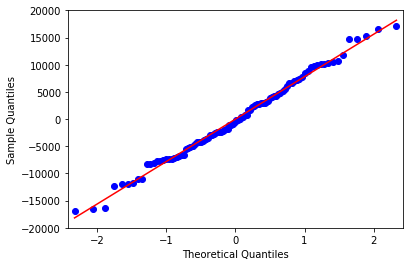

In [72]:
fig = sm.qqplot(residual, line = 'r')
plt.show()
fig.savefig("../data_visualization/Q-Q Plot for Car Fit.png")

In [73]:
temp = kpss(residual, regression = 'ct')
temp[1]

/Users/cslsh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/Users/cslsh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


0.1

In [74]:
temp = acorr_ljungbox(residual, lags = 2)
temp[1][0]

0.04716138254416765

In [75]:
residual

0     14718.916514
1     -3885.552908
2      3948.267883
3     -5323.540946
4    -11904.537159
          ...     
95     1592.962532
96     8414.852880
97    -1176.586344
98    -1095.813262
99     2939.459989
Length: 100, dtype: float64

In [76]:
sel_x_test = test_x[['WDXRSA_log', 'Days on Market', 'FIN_EM', 'DC_UR_log']]
test_X = sm.add_constant(sel_x_test)
#mod.predit(test_X)

In [77]:
test_y

101    303000.0
102    291000.0
103    300000.0
104    299000.0
105    290000.0
106    307000.0
107    300000.0
108    300000.0
109    315000.0
110    316000.0
111    317000.0
112    325000.0
113    318000.0
114    300000.0
115    315000.0
116    330000.0
Name: Median Sale Price, dtype: float64

In [80]:
np.mean(abs(residual))

6134.980863086658

In [81]:
np.mean(abs(residual)/train_y)

0.022775472299420056

In [78]:
np.mean((abs(res.predict(test_X) - test_y)))

6837.281727647009

In [79]:
np.mean((abs(res.predict(test_X) - test_y))/test_y)

0.022429211309385536

In [43]:
def MAE(pred_y, act_y):
    return np.mean(abs(res.predict(test_X) - test_y))

In [ ]:
def MAPE(pred_y, act_y):
    size = len(pred_y)
    ape = []
    for i in range(size):
        ape.append()

In [84]:
res.model.exog
het_breuschpagan(residual, res.model.exog)

(1.5330903243272243,
 0.8207642104471837,
 0.36977798249889937,
 0.8296370395166259)

In [90]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = het_breuschpagan(residual, res.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 1.5330903243272243),
 ('p-value', 0.8207642104471837),
 ('f-value', 0.36977798249889937),
 ('f p-value', 0.8296370395166259)]

In [94]:
name = ['F statistic', 'p-value']
test = het_goldfeldquandt(residual, res.model.exog)
lzip(name, test)

[('F statistic', 1.1294780199970185), ('p-value', 0.3423735915985968)]